In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load data
raw_data = pd.read_csv("Tractores_Matriculados.csv")
print(raw_data.head(), "\n")  # check data structure
print(raw_data.dtypes)  # check data types

        Fecha  Tractores
0  1986-01-31     1965.0
1  1986-02-28     1467.0
2  1986-03-31     1106.0
3  1986-04-30     1460.0
4  1986-05-31     1563.0 

Fecha         object
Tractores    float64
dtype: object


Fecha        datetime64[ns]
Tractores           float64
dtype: object


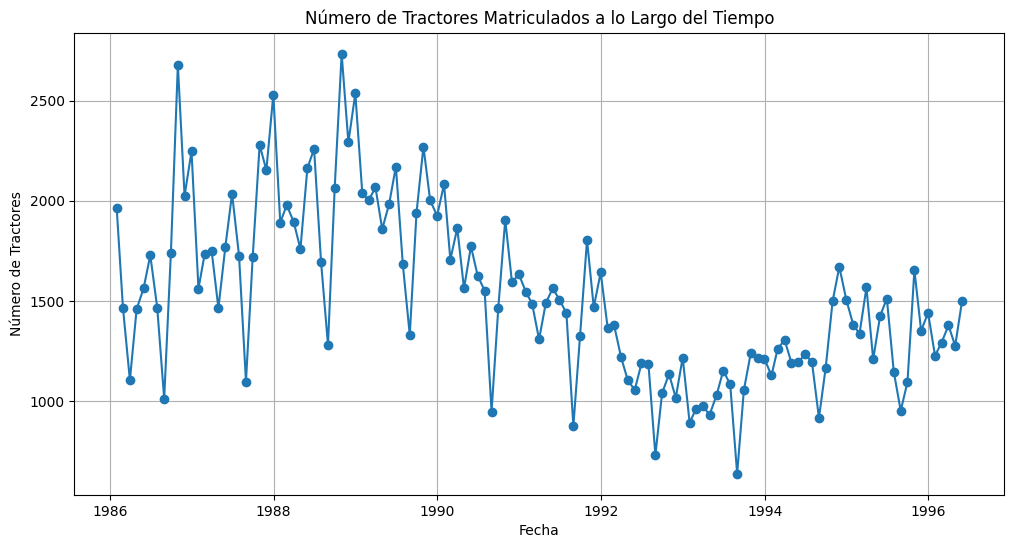

In [3]:
raw_data["Fecha"] = pd.to_datetime(
    raw_data["Fecha"], yearfirst=True
)  # convert to datetime object taking into account the year is first

print(raw_data.dtypes)  # check data types

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(raw_data["Fecha"], raw_data["Tractores"], marker="o")
plt.title("Número de Tractores Matriculados a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Número de Tractores")
plt.grid(True)
plt.show()

### Statistics

In [4]:
print(raw_data.describe(), "\n")  # summary statistics
print(raw_data.isna())  # check for missing values

"""
we can use raw_data.Fecha.descibe() to get a summary of the date column
"""

"""  
we can see in a specific column if there are missing values with: 
raw_data['column_name'].isna().sum()

If we want to fill the missing values with smth (in this case with the previus value) we can use:
raw_data.Tractores = raw_data.Tractores.fillna(
    method="ffill"
)
"""

                               Fecha    Tractores
count                            132   125.000000
mean   1991-07-16 06:10:54.545454592  1531.120000
min              1986-01-31 00:00:00   639.000000
25%              1988-10-23 06:00:00  1210.000000
50%              1991-07-15 12:00:00  1487.000000
75%              1994-04-07 12:00:00  1773.000000
max              1996-12-31 00:00:00  2734.000000
std                              NaN   425.232889 

     Fecha  Tractores
0    False      False
1    False      False
2    False      False
3    False      False
4    False      False
..     ...        ...
127  False       True
128  False       True
129  False       True
130  False       True
131  False       True

[132 rows x 2 columns]


'  \nwe can see in a specific column if there are missing values with: \nraw_data[\'column_name\'].isna().sum()\n\nIf we want to fill the missing values with smth (in this case with the previus value) we can use:\nraw_data.Tractores = raw_data.Tractores.fillna(\n    method="ffill"\n)\n'

In [5]:
# Filter data between 1988 t 1994
data = raw_data[
    (raw_data.Fecha >= "1986-01-31 00:00:00")
    & (raw_data.Fecha <= "1995-12-31 00:00:00")
]

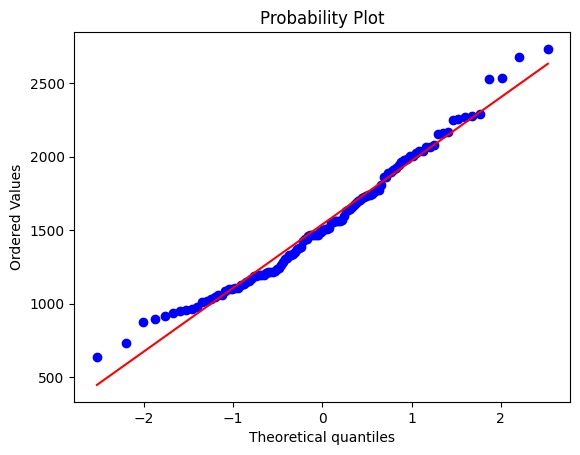

In [6]:
import scipy.stats as stats
import pylab

# Check for normality
stats.probplot(data.Tractores, dist="norm", plot=pylab)
pylab.show()

In [7]:
data.head()

,Fecha,Tractores
0,1986-01-31,1965.0
1,1986-02-28,1467.0
2,1986-03-31,1106.0
3,1986-04-30,1460.0
4,1986-05-31,1563.0


In [8]:
# Set date as index column and sort by date
data.set_index("Fecha", inplace=True)
data.head()

,Tractores
Fecha,
1986-01-31,1965.0
1986-02-28,1467.0
1986-03-31,1106.0
1986-04-30,1460.0
1986-05-31,1563.0


In [9]:
# data = data.asfreq("m")  # set frequency to monthly data
# data.head(50)

"""No funciona, no se puede convertir a frecuencia mensual -- da error"""

'No funciona, no se puede convertir a frecuencia mensual -- da error'

In [10]:
"""For delete column: 
del data['Tractores']

For add column for example: 
data['name new column'] = data['Tractores'] # copy the column Tractores to the new column
"""

"For delete column: \ndel data['Tractores']\n\nFor add column for example: \ndata['name new column'] = data['Tractores'] # copy the column Tractores to the new column\n"

### Split information in training set (80% data) and test set (20% data)

In [11]:
size_train = int(len(data) * 0.8)

train = data.iloc[:size_train]
test = data.iloc[size_train:]

test.head()

,Tractores
Fecha,
1994-01-31,1129.0
1994-02-28,1263.0
1994-03-31,1306.0
1994-04-30,1193.0
1994-05-31,1194.0


#### White noise

In [12]:
WN = np.random.normal(
    loc=train.Tractores.mean(), scale=train.Tractores.std(), size=len(train)
)  # create white noise for comparison

train["WN"] = WN  # add white noise to data
train.describe()  # for check the values

/var/folders/r4/_d0jbzx9629841ty8b0gfn040000gn/T/ipykernel_5773/1639053903.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["WN"] = WN  # add white noise to data


,Tractores,WN
count,96.000000,96.000000
mean,1597.406250,1508.045129
std,454.435047,411.650496
min,639.000000,687.202418
25%,1217.500000,1233.971903
50%,1563.500000,1527.070272
75%,1929.500000,1743.700210
max,2734.000000,2791.589284


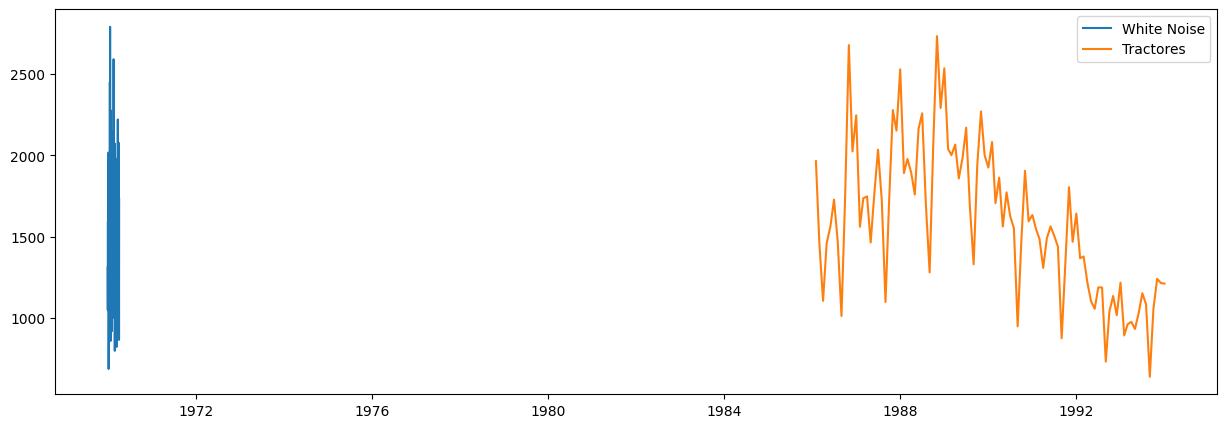

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(WN, label="White Noise")
plt.plot(train.Tractores, label="Tractores")
plt.legend()
plt.show()

In [14]:
# add addfuller
import statsmodels.tsa.stattools as sts

sts.adfuller(train.Tractores)

(np.float64(0.2868814852385955),
 np.float64(0.9767345464194086),
 12,
 83,
 {'1%': np.float64(-3.5117123057187376),
  '5%': np.float64(-2.8970475206326833),
  '10%': np.float64(-2.5857126912469153)},
 np.float64(1115.0467175014082))

## Determinamos si el modelo es aditivo o multiplicativo

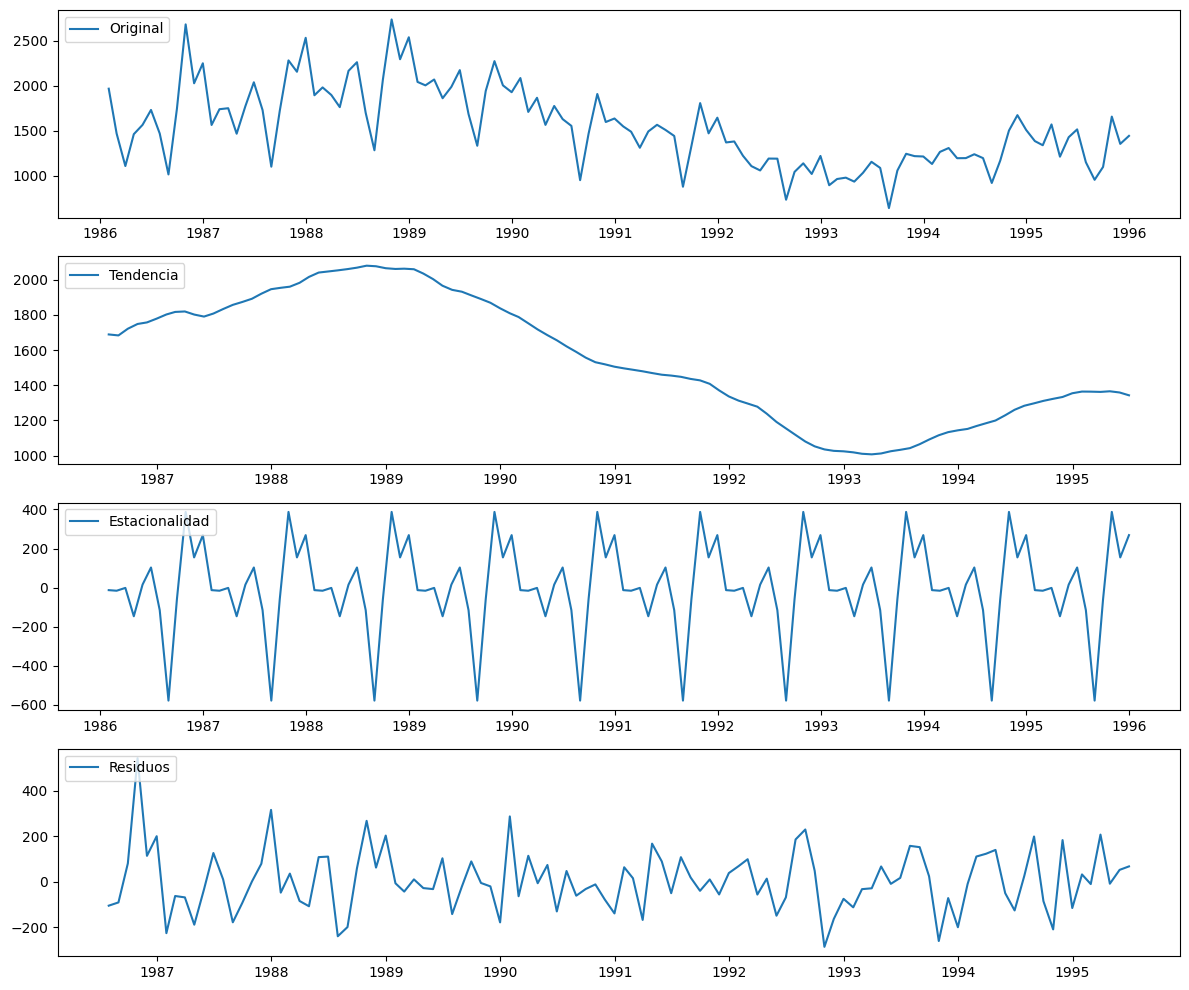

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizar la descomposición aditiva con los datos interpolados
decomposition_add = seasonal_decompose(data["Tractores"], model="additive", period=12)

# Graficar la descomposición aditiva
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(data["Tractores"], label="Original")
plt.legend(loc="upper left")

plt.subplot(412)
plt.plot(decomposition_add.trend, label="Tendencia")
plt.legend(loc="upper left")

plt.subplot(413)
plt.plot(decomposition_add.seasonal, label="Estacionalidad")
plt.legend(loc="upper left")

plt.subplot(414)
plt.plot(decomposition_add.resid, label="Residuos")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

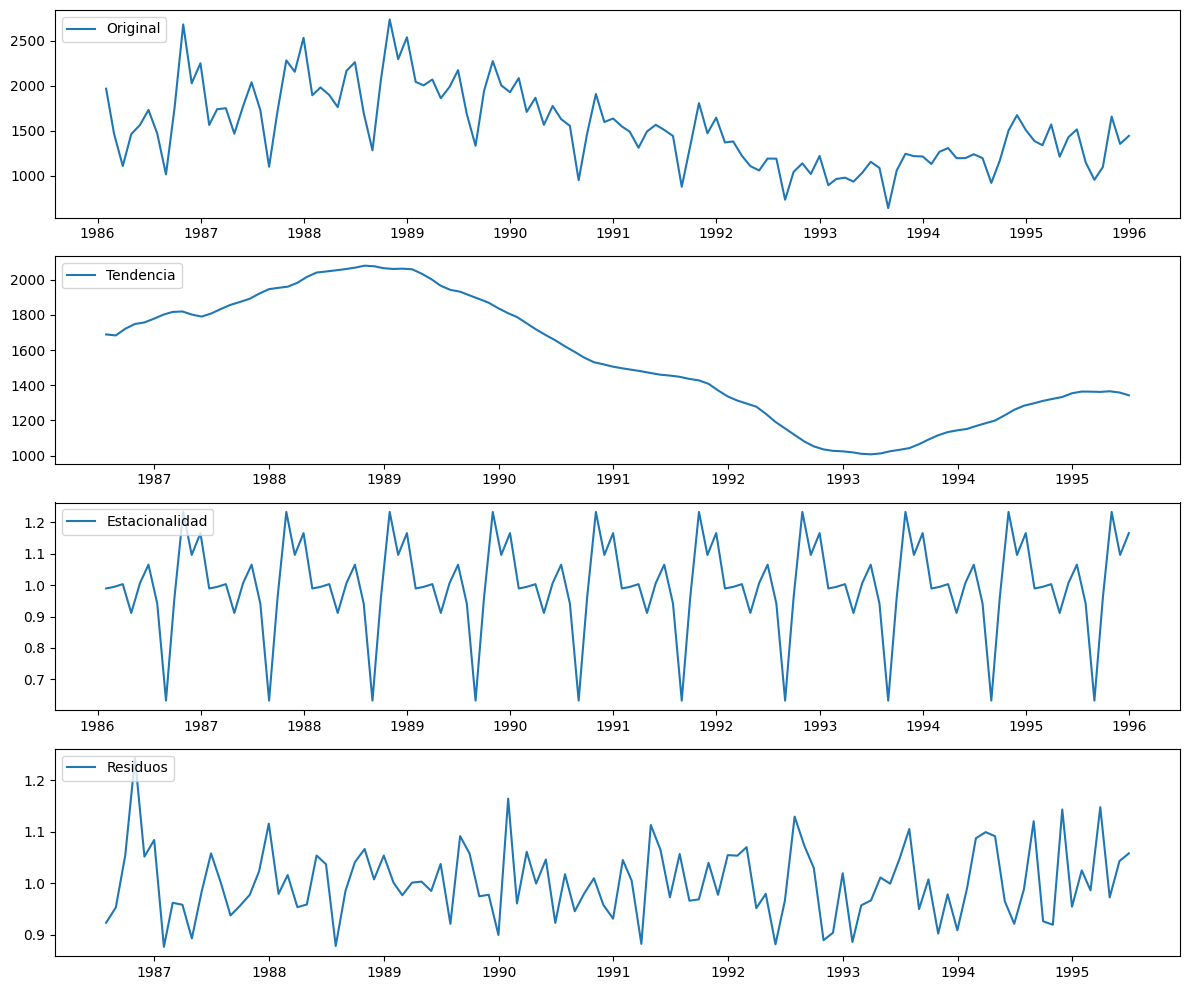

In [16]:
# Realizar la descomposición multiplicativa con los datos interpolados
decomposition_mult = seasonal_decompose(
    data["Tractores"], model="multiplicative", period=12
)

# Graficar la descomposición multiplicativa
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(data["Tractores"], label="Original")
plt.legend(loc="upper left")

plt.subplot(412)
plt.plot(decomposition_mult.trend, label="Tendencia")
plt.legend(loc="upper left")

plt.subplot(413)
plt.plot(decomposition_mult.seasonal, label="Estacionalidad")
plt.legend(loc="upper left")

plt.subplot(414)
plt.plot(decomposition_mult.resid, label="Residuos")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

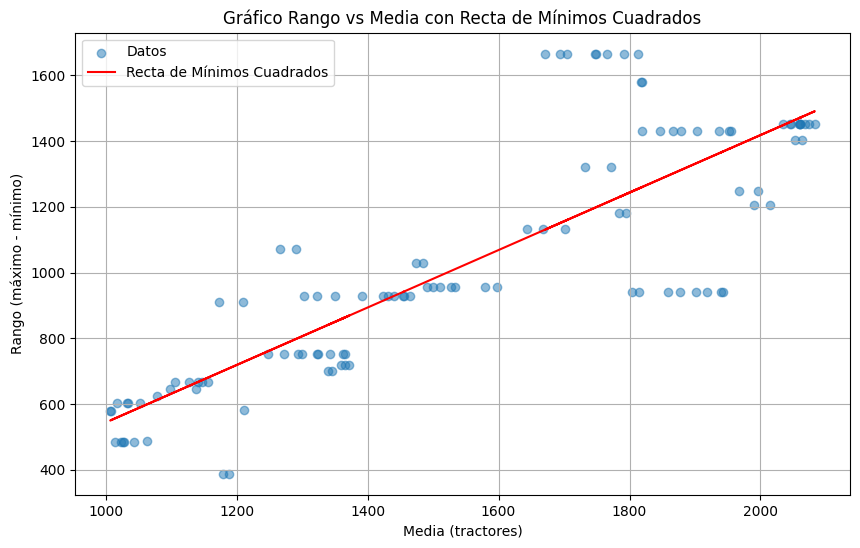

Coeficiente de determinación R^2: 0.7025104325971478
Pendiente de la recta: 0.8747235274572885
Intercepto de la recta: -330.9831230349863
Recta de mínimos cuadrados: y = 0.87x + -330.98

Podemos concluir con este y los anteriores gráficos que el mejor modelo que se ajusta es uno multiplicativo 


In [17]:
from sklearn.linear_model import LinearRegression

rolling_window = 12
rolling_mean = data["Tractores"].rolling(window=rolling_window).mean()
rolling_range = (
    data["Tractores"].rolling(window=rolling_window).apply(lambda x: x.max() - x.min())
)

# Eliminar NaN values resulted from rolling window operations
valid_idx = rolling_mean.dropna().index
valid_rolling_mean = rolling_mean.loc[valid_idx]
valid_rolling_range = rolling_range.loc[valid_idx]

# Reshape data for linear regression
X = valid_rolling_mean.values.reshape(-1, 1)
y = valid_rolling_range.values

# Ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir valores usando el modelo ajustado
y_pred = model.predict(X)

# Graficar el rango vs la media con la recta de mínimos cuadrados
plt.figure(figsize=(10, 6))
plt.scatter(valid_rolling_mean, valid_rolling_range, alpha=0.5, label="Datos")
plt.plot(valid_rolling_mean, y_pred, color="red", label="Recta de Mínimos Cuadrados")
plt.title("Gráfico Rango vs Media con Recta de Mínimos Cuadrados")
plt.xlabel("Media (tractores)")
plt.ylabel("Rango (máximo - mínimo)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Coeficiente de determinación R^2: {model.score(X, y)}")
print(f"Pendiente de la recta: {model.coef_[0]}")
print(f"Intercepto de la recta: {model.intercept_}")
print(
    f"Recta de mínimos cuadrados: y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}\n"
)

print(
    "Podemos concluir con este y los anteriores gráficos que el mejor modelo que se ajusta es uno multiplicativo "
)